# Testing our three models

## Imports

In [1]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
import plotly.express as px
from IPython.display import display
from sklearn.linear_model import LinearRegression
from collections.abc import Callable
from prophet import Prophet
import xgboost as xgb
from datetime import timedelta

In [2]:
#############
# Needed to suppress prophet output
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)
#############

## Fetching data

In [3]:
df = pd.read_csv("../consumption_temp.csv")
# Convert dftypes
df["time"] = pd.to_datetime(df["time"])
df["consumption"] = pd.to_numeric(df["consumption"])
df["temperature"] = pd.to_numeric(df["temperature"])

## Time-series split cross validation evaluation criteria

In [4]:

def time_series_split_validation(df, model_callback: Callable[[pd.DataFrame, pd.DataFrame], pd.DataFrame]):
    print("Evaluating", model_callback.__name__)

    df = df.copy()

    ret = pd.DataFrame()

    num_days = 30

    for loc in df.location.unique():
        print("Evaluating location", loc)
        tdf = df[df.location == loc][:-22] # needs to eliminate the last day with only 22 hrs to get full day tests
        tscv = TimeSeriesSplit(n_splits=num_days, gap=24*5, test_size=24) # gap=14 eliminates hours 10-23 of day before forecast

        counter = 1
        print("Forecast progress", end="")
        for split_tuple in tscv.split(tdf):
            print(" " + str(counter), end="")
            counter+=1

            fcst = model_callback(tdf.iloc[split_tuple[0]], tdf.iloc[split_tuple[1]])
            
            mape = (abs(fcst.consumption - fcst.yhat) / fcst.consumption).mean() * 100
            mae = (abs(fcst.consumption - fcst.yhat)).mean()
            
            fcst_date = fcst.time.dt.date.iloc[0]

            ret = pd.concat([ret, pd.DataFrame(data={'location': loc, 'forecast_date': fcst_date, 'mape': mape, 'mae': mae}, index=[0])])
        print()

    return ret.reset_index(drop=True)
            
            

## Model format

In [5]:
# all models will be in the following format
def naive_mean_model(df, future):
    """ df and future already filtered by location """
    df = df.copy()
    future = future.copy()
    
    mean = df.consumption.mean()
    future['yhat'] = mean

    return future

In [6]:
# all models will be in the following format
def naive_7_day_shift_model(df, future):
    """ df and future already filtered by location """
    df = df.copy()
    future = future.copy()

    y_pred = future.time.apply(lambda time : df[df.time == (pd.to_datetime(time)-timedelta(days=7))].consumption.iloc[0])

    future['yhat'] = y_pred

    return future

In [7]:
for loc in df.location.unique():
    filtered_df = df[df.location == loc]
    fcst = naive_7_day_shift_model(filtered_df.iloc[:-24], filtered_df.iloc[-24:])
    # display(filtered_df.tail(500))
    display(fcst)

,time,location,consumption,temperature,yhat
49350,2023-04-01 22:00:00,bergen,2.848528,-0.8,2.848528
49356,2023-04-01 23:00:00,bergen,2.729397,-1.0,2.729397
49362,2023-04-02 00:00:00,bergen,2.686501,-0.9,2.686501
49368,2023-04-02 01:00:00,bergen,2.606383,-0.8,2.606383
49374,2023-04-02 02:00:00,bergen,2.605855,-0.5,2.605855
49380,2023-04-02 03:00:00,bergen,2.623562,-0.6,2.623562
49386,2023-04-02 04:00:00,bergen,2.645794,-0.3,2.645794
49392,2023-04-02 05:00:00,bergen,2.735909,-1.5,2.735909
49398,2023-04-02 06:00:00,bergen,2.864698,-0.1,2.864698
49404,2023-04-02 07:00:00,bergen,2.959196,3.6,2.959196


,time,location,consumption,temperature,yhat
49352,2023-04-01 22:00:00,oslo,10.854571,-3.0,10.854571
49358,2023-04-01 23:00:00,oslo,10.602637,-3.2,10.602637
49364,2023-04-02 00:00:00,oslo,10.360518,-3.8,10.360518
49370,2023-04-02 01:00:00,oslo,10.263785,-4.2,10.263785
49376,2023-04-02 02:00:00,oslo,10.199984,-4.5,10.199984
49382,2023-04-02 03:00:00,oslo,10.238265,-4.8,10.238265
49388,2023-04-02 04:00:00,oslo,10.224077,-4.6,10.224077
49394,2023-04-02 05:00:00,oslo,10.455363,-3.6,10.455363
49400,2023-04-02 06:00:00,oslo,10.845660,-2.4,10.845660
49406,2023-04-02 07:00:00,oslo,11.227606,0.1,11.227606


,time,location,consumption,temperature,yhat
49353,2023-04-01 22:00:00,stavanger,4.944286,-1.1,4.944286
49359,2023-04-01 23:00:00,stavanger,4.863903,-2.0,4.863903
49365,2023-04-02 00:00:00,stavanger,4.741552,-2.6,4.741552
49371,2023-04-02 01:00:00,stavanger,4.657625,-2.6,4.657625
49377,2023-04-02 02:00:00,stavanger,4.666595,-2.5,4.666595
49383,2023-04-02 03:00:00,stavanger,4.642884,-2.5,4.642884
49389,2023-04-02 04:00:00,stavanger,4.678426,-2.1,4.678426
49395,2023-04-02 05:00:00,stavanger,4.774565,-1.5,4.774565
49401,2023-04-02 06:00:00,stavanger,4.959825,-0.3,4.959825
49407,2023-04-02 07:00:00,stavanger,5.328527,2.5,5.328527


,time,location,consumption,temperature,yhat
49354,2023-04-01 22:00:00,tromsø,1.961562,-3.1,1.961562
49360,2023-04-01 23:00:00,tromsø,1.946432,-3.4,1.946432
49366,2023-04-02 00:00:00,tromsø,1.899790,-3.5,1.899790
49372,2023-04-02 01:00:00,tromsø,1.879640,-3.6,1.879640
49378,2023-04-02 02:00:00,tromsø,1.849327,-3.6,1.849327
49384,2023-04-02 03:00:00,tromsø,1.850490,-3.7,1.850490
49390,2023-04-02 04:00:00,tromsø,1.828810,-3.9,1.828810
49396,2023-04-02 05:00:00,tromsø,1.868492,-4.2,1.868492
49402,2023-04-02 06:00:00,tromsø,1.875634,-2.7,1.875634
49408,2023-04-02 07:00:00,tromsø,1.926797,-1.9,1.926797


,time,location,consumption,temperature,yhat
49355,2023-04-01 22:00:00,trondheim,3.511587,-3.7,3.511587
49361,2023-04-01 23:00:00,trondheim,3.414305,-4.4,3.416190
49367,2023-04-02 00:00:00,trondheim,3.392195,-4.1,3.394977
49373,2023-04-02 01:00:00,trondheim,3.413653,-4.3,3.422895
49379,2023-04-02 02:00:00,trondheim,3.415748,-6.6,3.420887
49385,2023-04-02 03:00:00,trondheim,3.435766,-9.0,3.436387
49391,2023-04-02 04:00:00,trondheim,3.527316,-9.5,3.524546
49397,2023-04-02 05:00:00,trondheim,3.557062,-8.9,3.554167
49403,2023-04-02 06:00:00,trondheim,3.682280,-7.0,3.673676
49409,2023-04-02 07:00:00,trondheim,3.815020,-3.5,3.811004


,time,location,consumption,temperature,yhat
49351,2023-04-01 22:00:00,helsingfors,6.331,-1.6,6.331
49357,2023-04-01 23:00:00,helsingfors,6.328,-2.0,6.328
49363,2023-04-02 00:00:00,helsingfors,6.291,-2.4,6.291
49369,2023-04-02 01:00:00,helsingfors,6.286,-2.9,6.286
49375,2023-04-02 02:00:00,helsingfors,6.299,-3.2,6.299
49381,2023-04-02 03:00:00,helsingfors,6.306,-3.5,6.306
49387,2023-04-02 04:00:00,helsingfors,6.290,-3.9,6.290
49393,2023-04-02 05:00:00,helsingfors,6.289,-4.0,6.289
49399,2023-04-02 06:00:00,helsingfors,6.281,-3.5,6.281
49405,2023-04-02 07:00:00,helsingfors,6.265,-2.6,6.265


## Linear regression

In [8]:

def linear_model(df, future):
    df = df.copy()
    future = future.copy()
    
    model = LinearRegression()

    # Fit the model to the training data
    model.fit(df.temperature.values.reshape(-1, 1), df.consumption.values.reshape(-1, 1))

    # Make predictions on the test data
    y_pred = model.predict(future.temperature.values.reshape(-1, 1))
    future['yhat'] = y_pred

    return future

## Prophet

In [9]:

def prophet_model(df, future):
    df = df.copy()
    future = future.copy()
    
    model = Prophet()
    model.add_regressor('temperature')
    model.fit(df.rename(columns={'time': 'ds', 'consumption': 'y'}))

    # Make predictions on the test data
    y_pred = model.predict(future.rename(columns={'time': 'ds'})).yhat.values
    future['yhat'] = y_pred

    return future

## XGBoost

In [10]:

def xgboost_model(df, future):
    df = df.copy()
    future = future.copy()

    # creating time series features (chatgpt suggestions)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df['day_of_week'] = df['time'].dt.dayofweek
    df['day_of_year'] = df['time'].dt.dayofyear
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    future['year'] = future['time'].dt.year
    future['month'] = future['time'].dt.month
    future['day'] = future['time'].dt.day
    future['hour'] = future['time'].dt.hour
    future['day_of_week'] = future['time'].dt.dayofweek
    future['day_of_year'] = future['time'].dt.dayofyear
    future['hour_sin'] = np.sin(2 * np.pi * future['hour'] / 24)
    future['hour_cos'] = np.cos(2 * np.pi * future['hour'] / 24)

    # Create and train an XGBoost model
    # Standard hyperparameters for prototyping, no gridsearch or similar
    model = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=5,
        learning_rate=0.1,
        objective="reg:absoluteerror", #"reg:squarederror",
        random_state=42,
    )
    X = df[['temperature', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_of_year', 'hour_sin', 'hour_cos']]
    y = df['consumption']
    model.fit(X, y)

    # Make predictions on the test set
    X_test = future[['temperature', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_of_year', 'hour_sin', 'hour_cos']]
    y_pred = model.predict(X_test)

    future['yhat'] = y_pred

    return future[['time', 'location', 'consumption', 'temperature', 'yhat']]



## Evaluation

In [11]:
out = pd.DataFrame()

for model_callback in [naive_7_day_shift_model, linear_model, prophet_model, xgboost_model]:
    model_name = model_callback.__name__
    ret = time_series_split_validation(df, model_callback)[['location', 'mape']]
    ret = ret.groupby('location').mean().reset_index()
    ret['model'] = model_name
    out = pd.concat([out, ret[['location', 'model', 'mape']]])


Evaluating naive_7_day_shift_model
Evaluating location bergen
Forecast progress 1 2
Evaluating location oslo
Forecast progress 1 2
Evaluating location stavanger
Forecast progress 1 2
Evaluating location tromsø
Forecast progress 1 2
Evaluating location trondheim
Forecast progress 1 2
Evaluating location helsingfors
Forecast progress 1 2
Evaluating linear_model
Evaluating location bergen
Forecast progress 1 2
Evaluating location oslo
Forecast progress 1 2
Evaluating location stavanger
Forecast progress 1 2
Evaluating location tromsø
Forecast progress 1 2
Evaluating location trondheim
Forecast progress 1 2
Evaluating location helsingfors
Forecast progress 1 2
Evaluating prophet_model
Evaluating location bergen
Forecast progress 1 2
Evaluating location oslo
Forecast progress 1

KeyboardInterrupt: 

In [ ]:
outcpy = out.copy()
outcpy.sort_values('mape', ascending=False, inplace=True)

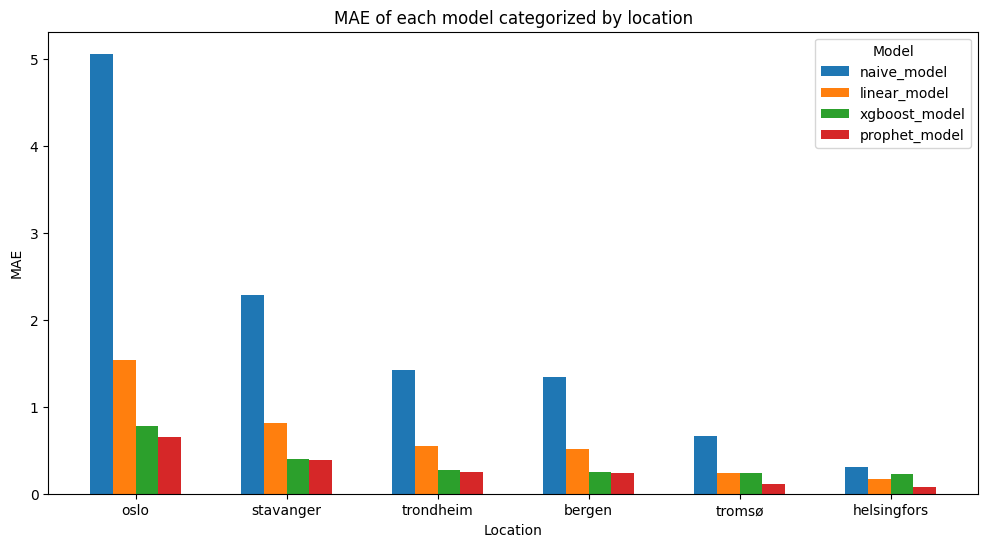

In [ ]:
# Get unique models and locations
models = outcpy['model'].unique()
locations = outcpy['location'].unique()

# Create a dodged (side-by-side) bar plot with 'model' and 'location' switched
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
bar_positions = range(len(locations))

for i, model in enumerate(models):
    model_data = outcpy[outcpy['model'] == model]
    x_values = [pos + i * bar_width for pos in bar_positions]
    y_values = model_data['mape']
    
    ax.bar(x_values, y_values, width=bar_width, label=model)

ax.set_xticks([pos + (bar_width * (len(models) - 1) / 2) for pos in bar_positions])
ax.set_xticklabels(locations)
ax.set_xlabel('Location')
ax.set_ylabel('MAPE')
ax.set_title('MAPE of each model categorized by location')
plt.legend(title='Model')

plt.show()